In [1]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [2]:
core_path = os.getcwd()
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [5]:
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus Class"].to_list())

In [7]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [8]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [9]:
# Get the number of inputs
n_inputs = asteroids_X.shape[1]

# Bottleneck size
n_bottleneck = 2

def create_model():
    
    # Input layer
    input_layer = keras.Input(shape=(n_inputs, 1))
    
    # --------------------
    # Encoder (Trial 14 params)
    # --------------------
    hidden_layer = keras.layers.Conv1D(
        filters=32,              # 1_filter
        kernel_size=6,           # 1_kernal
        activation="relu",
        padding="same"
    )(input_layer)

    hidden_layer = keras.layers.Conv1D(
        filters=128,             # 2_filter
        kernel_size=4,           # 2_kernal
        activation="relu",
        padding="same"
    )(hidden_layer)
    
    # Bottleneck
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck, name="bottleneck")(bottleneck_lay)

    # --------------------
    # Decoder (mirror)
    # --------------------
    reset_lay = keras.layers.Dense(49 * 128)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 128))(reset_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=128,
        kernel_size=4,
        activation="relu",
        padding="same"
    )(reshape_lay)

    hidden_layer = keras.layers.Conv1DTranspose(
        filters=32,
        kernel_size=6,
        activation="relu",
        padding="same"
    )(hidden_layer)

    # Output layer
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Models
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)

    return model, encoder_model


# Build models
model, encoder_model = create_model()

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="mse"
)

# Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 49, 32)         │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 49, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │        12,546 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6272)           │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 49, 128)        │        65,664 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 49, 32)         │        24,608 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 49, 1)          │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,403 (540.64 KB)

 Trainable params: 138,403 (540.64 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.25,
                    callbacks=[es_callback])

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5070 - val_loss: 0.2122
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1475 - val_loss: 0.0507
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0433 - val_loss: 0.0309
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0332 - val_loss: 0.0288
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0297 - val_loss: 0.0282
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0286 - val_loss: 0.0268
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0278 - val_loss: 0.0263
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0288 - val_loss: 0.0273
Epoch 9/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0278 - val_loss: 0.0263
Epoch 10/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0274 - val_loss: 0.0279
Epoch 11/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0282 - val_loss: 0.0272
Epoch 12/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss

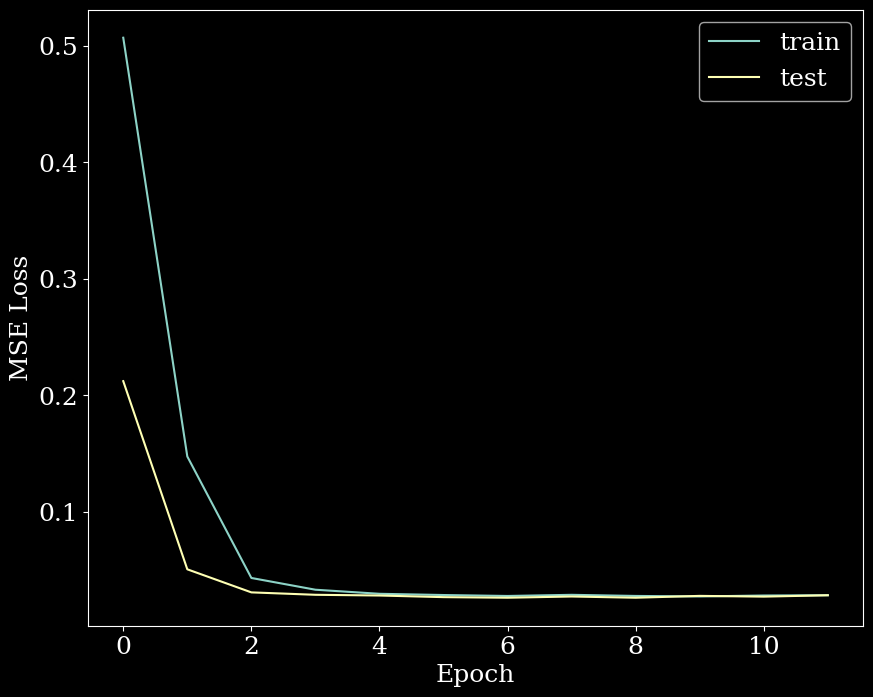

In [11]:
# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

# ... aaaaand plot!
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


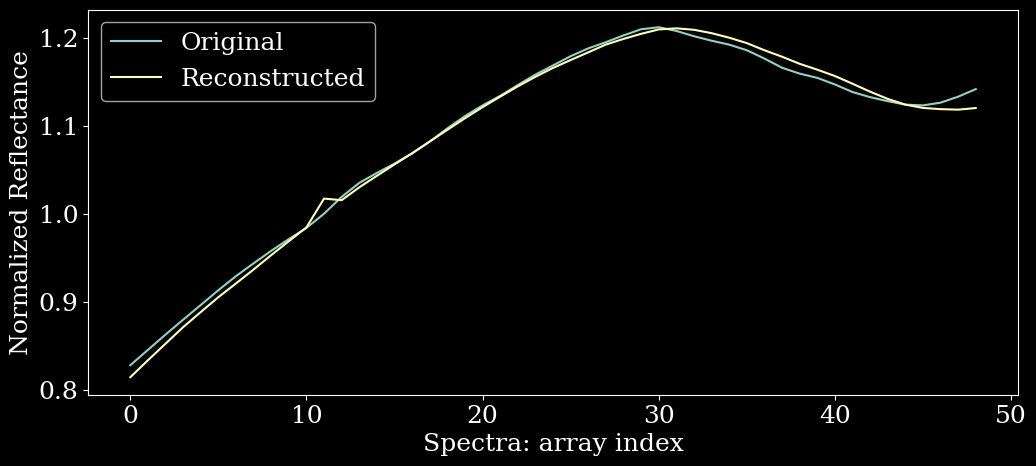

In [25]:
# Which index shall be displayed?
index_val = 5

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

# ... aaaaand plot!
plt.show()